# Introduction

In this project, we are interested in developing a binary text classification model that can identify Tweets about natural disasters. Our data is a collection of 7613 Tweets compiled for a [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data) and classified as related or unrelated to natural disasters. The competition also includes a holdout set of 3264 classified Tweets. The actual classifications of these Tweets are unknown to us, but Kaggle uses the actual classifications to compute an F1 score for the predicted classifications made by models developed for the competition. In the following code block, we import the libraries, functions, and classes we need for this project along with the training data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
tf.keras.utils.set_random_seed(327)
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

# Data exploration

Below, we view the first few rows of the data set, look at the data type of each column, and search for any null values.

In [2]:
print(df.head(), "\n\n")
print(df.info(), "\n\n")
print("null values:")
print(df.isna().sum())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 


null values:
id             0


The data set includes columns recording an aribtrary identification numbers, keywords, and locations. The identification numbers do not carry any useful information for classification. Ostensibly, locations could provide useful information (i.e., whether Tweets were posted from locations that have suffered natural disasters in the time period over which this data was collected), but a large portion of the Tweets (33%) are missing locations. Keywords could easily provide useful information, and all but 61 of the rows in the data set have keywords. However, we are interested in a natural language processing approach that identifies disaster-related Tweets from the Tweet texts themselves.

Below, we see histograms representing the distribution of Tweet text lengths by character and word.

Distribution of character lengths:


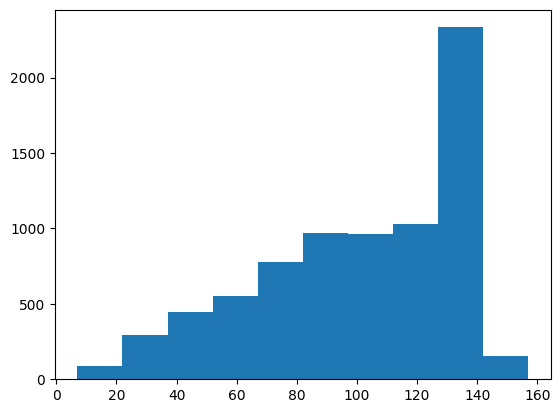

In [3]:
df["ch_len"] = df["text"].apply(len)
df["wd_len"] = df["text"].apply(lambda t: len(t.split(" ")))
print("Distribution of character lengths:")
plt.hist(df["ch_len"])
plt.show()

Distribution of word lengths:


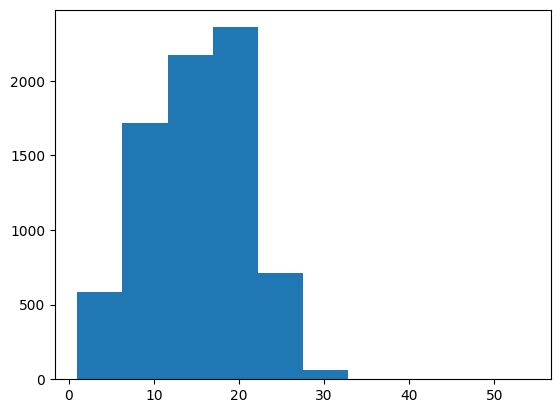

In [4]:
print("Distribution of word lengths:")
plt.hist(df["wd_len"])
plt.show()

We also check the distribution of the `target` column, in which `1` and `0` indicate whether a Tweet is about a natural disaster.

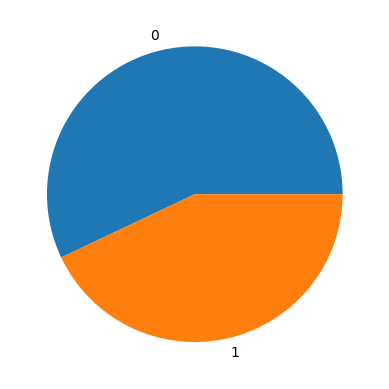

In [5]:
target_counts = df["target"].value_counts()
plt.pie(target_counts, labels = target_counts.index)
plt.show()

There is a slight underrepresentation of Tweets about natural disasters. This imbalance might cause our model to become slightly biased against classifying Tweets as relating to disasters, but since the imbalance is relatively small, we will not use any special sampling techniques to balance the data set at this time.

# Preprocessing

In order to train a deep learning model, we need to encode each Tweet as a sequence of numbers. The natural way to proceed is to assign each word an integer. However, we should perform this encoding step with some care because there are many ways of writing words that are more or less the same. We almost certainly want "disaster" and "Disaster" to be represented with the same number, and we may even want "disaster" and "disastrous" to be represented with the same number.

The following code block defines two functions to process the text before ecoding it with integers. The first function cleans the text by casting every letter in lower case as well as removing digits, punctuation, and special characters. The second one uses the `spacy` library to lemmatize each word (i.e., replace inflected words like "disastrous" with root words like "disaster"). In order to limit the number of low-information words seen by our model, the lemmatization function also filters out stop words and words whose lemmatized form is 3 characters or less.

In [6]:
def clean_text(t):
    t = t.lower()
    t = re.sub(r'\d+', '', t)
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\W', ' ', t)
    return t
nlp = spacy.load("en_core_web_sm")
def lemmatize(t):
    lemmas = [w.lemma_ for w in nlp(t) if not w.is_stop and len(w.lemma_) > 3]
    return " ".join(lemmas)

Below, we apply the cleaning and lemmatization functions to the Tweet texts and view a few lilnes of the result.

In [7]:
df["text"] = df["text"].apply(clean_text)
df["text"] = df["text"].apply(lemmatize)
df["text"].head()

0                 deed reason earthquake allah forgive
1                   forest fire near ronge sask canada
2    resident shelter place notify officer evacuati...
3    people receive wildfire evacuation order calif...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

Finally, we partition the data into a training/validation split, and we use the training data to fit an encoder. The encoder is the object that will assign a unique integer to each lemmatized word in the training set.

In [8]:
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 328)

In [9]:
encoder = tf.keras.layers.TextVectorization(max_tokens = 10000)
encoder.adapt(df_train["text"])
vocabulary = np.array(encoder.get_vocabulary())

# Initial model

We use a deep learning model for this classification task. The first three layers of the model contain gated recurrent units (GRUs), whose outputs are passed to subsequent layers and also back into themselves. In this way, the GRUs are potentially capable of learning the syntactic relationships among words (i.e., how a word's meaning depends on previous words meaning). The outpur from the GRU layers is fed into four dense layers with ReLU activation for classification, and the output layer has sigmoid activation for binary classification.

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(vocabulary), 128, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.build(input_shape = (1,))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, None)                   │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (1, None, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, None, 256)              │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (1, None, 128)              │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (1, 64)                     │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 256)                    │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,692,801 (6.46 MB)

 Trainable params: 1,692,801 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

Now, we train the model over up to 100 epochs using binary cross-entropy as a loss function and `Adam` as an optimizer. Since we intend to let Kaggle validate the model according to its F1 score, we choose F1 as a primary metric. However, computing F1 subscores batch by batch does not always give a clear picture of how model performance is evolving over the epochs, so we include simple accuracy as a secondary metric. We set the training cycle to stop early after 10 epochs with no increase in F1 score.

In [11]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [F1Score(name = "f1"), "acc"]
)
f1_early_stopping = EarlyStopping(
    monitor = "val_f1", 
    patience = 10,
    restore_best_weights = True
)
history = model.fit(
    df_train["text"], 
    df_train["target"],
    epochs = 100,
    callbacks = [f1_early_stopping],
    validation_data = (df_val["text"], df_val["target"])
)

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - acc: 0.6590 - f1: 0.5989 - loss: 0.6042 - val_acc: 0.8076 - val_f1: 0.5995 - val_loss: 0.4424
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - acc: 0.8762 - f1: 0.5989 - loss: 0.3172 - val_acc: 0.7794 - val_f1: 0.5995 - val_loss: 0.5366
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - acc: 0.9454 - f1: 0.5989 - loss: 0.1506 - val_acc: 0.7387 - val_f1: 0.5995 - val_loss: 0.7124
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - acc: 0.9706 - f1: 0.5989 - loss: 0.1003 - val_acc: 0.7098 - val_f1: 0.5995 - val_loss: 0.7644
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - acc: 0.9752 - f1: 0.5989 - loss: 0.0743 - val_acc: 0.7505 - val_f1: 0.5995 - val_loss: 1.0176
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - acc: 0.9747 - f1: 0.5989 - loss: 0.0847 - val_acc: 0.7544 - val_f1: 0.5995 - val_loss: 1.0083
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - acc: 0.9747 - f1: 0.5989 - loss: 0.07

Noteably, there is virtually no movement in the F1 scores over the first 12 epochs on either the training or validation data. This is likely due in part to the unreliable nature of F1 scores computed batch by batch. The actual F1 score on the entire validation set computed below.

In [12]:
def f1(mod):
    y_pred = 1*(mod.predict(df_val["text"]) > 0.5)
    y_true = np.array(df_val["target"]).reshape(-1,1)
    precision = sum((y_pred * y_true))/sum(y_true)
    recall = sum((y_pred * y_true))/sum(y_pred)
    return 2*precision*recall/(precision + recall)
print(f"initial model f1 = {f1(model)[0]}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
initial model f1 = 0.7568464730290456


The model's low F1 score might be a sign of some bias entering the model because of the class imbalance observed earlier. To be on the safe side, we will repartition our data, sampling in such a way as to have more balanced `target` distributions in our training and validation data.

# Balancing the training set

Below, we separate out the positive class (`"target" == 1`) into a dataframe `pos_df`. We then sample a number of rows from the negative class equal to the number of rows in the positive class and combine these to create a balanced dataframe with 6542 rows. 

In [13]:
pos_df = df[df["target"] == 1]
num_pos = df["target"].value_counts()[1]
neg_df = df[df["target"] == 0].sample(num_pos, random_state = 329)
bal_df = pd.concat([pos_df, neg_df]).sort_index()
bal_df

,id,keyword,location,text,target,ch_len,wd_len
0,1,NaN,NaN,deed reason earthquake allah forgive,1,69,13
1,4,NaN,NaN,forest fire near ronge sask canada,1,38,7
2,5,NaN,NaN,resident shelter place notify officer evacuati...,1,133,22
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1,65,9
4,7,NaN,NaN,send photo ruby alaska smoke wildfires pour sc...,1,88,17
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,giant crane hold bridge collapse nearby home h...,1,83,11
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fire calif...,1,125,20
7610,10871,NaN,NaN,utckm volcano hawaii httptcozdtoydebj,1,65,8
7611,10872,NaN,NaN,police investigate ebike collide little portug...,1,137,19


We now repartition the data into a training/validation split and retrain the initial model.

In [14]:
df_train, df_val = train_test_split(bal_df, test_size = 0.2, random_state = 330)

In [15]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [F1Score(name = "f1"), "acc"]
)
f1_early_stopping = EarlyStopping(
    monitor = "val_f1", 
    patience = 10,
    restore_best_weights = True
)
history = model.fit(
    df_train["text"], 
    df_train["target"],
    epochs = 100,
    callbacks = [f1_early_stopping],
    validation_data = (df_val["text"], df_val["target"])
)
print("Prediction")
print(f"initial model f1 = {f1(model)[0]}")

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - acc: 0.8550 - f1: 0.6682 - loss: 0.3508 - val_acc: 0.8587 - val_f1: 0.6677 - val_loss: 0.3391
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.9074 - f1: 0.6682 - loss: 0.2308 - val_acc: 0.8411 - val_f1: 0.6677 - val_loss: 0.4158
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - acc: 0.9445 - f1: 0.6682 - loss: 0.1454 - val_acc: 0.8312 - val_f1: 0.6677 - val_loss: 0.4647
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - acc: 0.9656 - f1: 0.6682 - loss: 0.1021 - val_acc: 0.8151 - val_f1: 0.6677 - val_loss: 0.5495
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.9733 - f1: 0.6682 - loss: 0.0861 - val_acc: 0.8075 - val_f1: 0.6677 - val_loss: 0.7021
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - acc: 0.9763 - f1: 0.6682 - loss: 0.0772 - val_acc: 0.7785 - val_f1: 0.6677 - val_loss: 0.9502
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.9743 - f1: 0.6682 - loss: 0.07

Balancing the training and validation data caused the F1 scores to increase noticeably, although there is still no movement in the batch-by-batch F1 score. When we examine the accuracy and loss scores, we see a clear pattern: epoch by epoch, the model shows greater accuracy and lower loss on training data while showing lower accuracy and higher loss on validation data. This is a clear sign of overfitting, and it appears after only one epoch.

# Model with dropout layers

To address the overfitting evident in the training history of our first model, we experiment with adding dropout layers with dropot rate 0.2. With each batch, a dropout layer randomly severs 20% of the connections between the layer before and after, meaning that the model behaves somewhat like a large ensemble of smaller models being trained simultaneously. The code below implements the dropout layers and performs a training cycle. Since batch-by-batch F1 scores are not informative with respect to the evolution of model performance over epochs, we modify the early stopping object to monitor validation loss.

In [16]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(vocabulary), 128, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model2.build(input_shape = (1,))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, None)                   │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (1, None, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (1, None, 256)              │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, None, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (1, None, 128)              │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (1, 64)                     │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 256)                    │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,692,801 (6.46 MB)

 Trainable params: 1,692,801 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [F1Score(name = "f1"), "acc"]
)
loss_early_stopping = EarlyStopping(
    monitor = "val_loss", 
    patience = 10,
    mode = "min",
    restore_best_weights = True,
    verbose = 1
)
history2 = model2.fit(
    df_train["text"], 
    df_train["target"],
    epochs = 100,
    callbacks = [loss_early_stopping],
    validation_data = (df_val["text"], df_val["target"])
)
print(f"dropout model f1 = {f1(model2)[0]}")

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - acc: 0.6046 - f1: 0.6682 - loss: 0.6251 - val_acc: 0.7937 - val_f1: 0.6677 - val_loss: 0.4581
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.8384 - f1: 0.6682 - loss: 0.3733 - val_acc: 0.7785 - val_f1: 0.6677 - val_loss: 0.6462
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.9355 - f1: 0.6682 - loss: 0.1928 - val_acc: 0.7632 - val_f1: 0.6677 - val_loss: 0.6417
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.9636 - f1: 0.6683 - loss: 0.1163 - val_acc: 0.7586 - val_f1: 0.6677 - val_loss: 1.0278
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.9707 - f1: 0.6684 - loss: 0.0908 - val_acc: 0.7471 - val_f1: 0.6677 - val_loss: 0.9619
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.9717 - f1: 0.6682 - loss: 0.0946 - val_acc: 0.7074 - val_f1: 0.6677 - val_loss: 1.2226
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.9687 - f1: 0.6682 - loss: 0.09

The dropout layers unfortunately do not seem to prevent overfitting. Accuracy and loss continue to improve on training data and to get worse on validation data. In the next section, we consider the optimizer's learning rate. This learning rate can also help to control overfitting, and we tune it simultaneously with the dropout rate.

# Dropout and learning rate tuning

The following cell defines two functions: one function that takes a dropout rate `d` as its input and returns a `Sequential` model with four dropout layers with rate `d`, and a second function that takes a model `mod` and a learning rate `r` as its input and trains `mod` using optimizer `Adam(learning_rate = r)`.

In [18]:
def create_mod(d):
    mod = Sequential([
        encoder,
        tf.keras.layers.Embedding(
            len(vocabulary), 128, mask_zero = True),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
        tf.keras.layers.Dropout(d),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
        tf.keras.layers.Dropout(d),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(d),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(d),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    mod.build(input_shape = (1,))
    return mod
def train_mod(mod, r):
    mod.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(r),
        metrics = [F1Score(name = "f1"), "acc"]
    )
    es = EarlyStopping(
        monitor = "val_loss", 
        patience = 5,
        restore_best_weights = True,
        verbose = 1
    )
    hist = mod.fit(
        df_train["text"], 
        df_train["target"],
        epochs = 100,
        callbacks = [es],
        validation_data = (df_val["text"], df_val["target"])
    )
    return hist

We now perform cross validation to tune dropout rate `d` over `[0.1, 0.2, 0.4, 0.8]` and learing rate `r` over `[0.00001, 0.0001, 0.001]`. After training a model with each combination of hyperparameters `d` and `r`, we check the F1 score.

In [19]:
models = {}
histories = {}
dropout_rates = [0, 0.1, 0.2, 0.4, 0.8]
learning_rates = [0.00001, 0.0001, 0.001]
f1_scores = pd.DataFrame(
    np.zeros((5,3)),
    index = dropout_rates,
    columns = learning_rates
)
for d in dropout_rates:
    for r in learning_rates:
        print(f"Training model with dropout rate {d} and learning rate {r}")
        mod = create_mod(d)
        hist = train_mod(mod,r)
        models[(d,r)] = mod
        histories[(d,r)] = hist
        score = f1(mod)[0]
        f1_scores.loc[d,r] = score
        print(f"f1 score = {score}")
        if d*r < 0.8 * 0.001:
            print("\n\n\n")

Training model with dropout rate 0 and learning rate 1e-05
Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - acc: 0.5002 - f1: 0.6682 - loss: 0.6932 - val_acc: 0.5065 - val_f1: 0.6677 - val_loss: 0.6931
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.5128 - f1: 0.6682 - loss: 0.6930 - val_acc: 0.5325 - val_f1: 0.6677 - val_loss: 0.6928
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.5438 - f1: 0.6682 - loss: 0.6927 - val_acc: 0.5875 - val_f1: 0.6677 - val_loss: 0.6921
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - acc: 0.6055 - f1: 0.6682 - loss: 0.6918 - val_acc: 0.6509 - val_f1: 0.6677 - val_loss: 0.6900
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - acc: 0.6686 - f1: 0.6682 - loss: 0.6889 - val_acc: 0.6937 - val_f1: 0.6677 - val_loss: 0.6845
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - acc: 0.7097 - f1: 0.6682 - loss: 0.6807 - val_acc: 0.7296 - val_f1: 0.6677 - val_loss: 0.6703
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━

# Discussion

Below, we see loss plots from two training histories tested in the previous section, both with dropout rates of 0.2. The first plot illustrates training with a learning rate of 0.001 (the default setting used by our initial model). In this plot, we see validation loss increase steadily starting immediately after the first epoch even as training loss steadily decreases. This is typical of overfitting. The second plot illustrates training with a learning rate of 0.00001, and with this slower learning rate, we see both validation and training loss decrease approximately in parallel for several epochs. This is an indication that the model does not overfit as dramatically when its learning rate is set to a lower value.

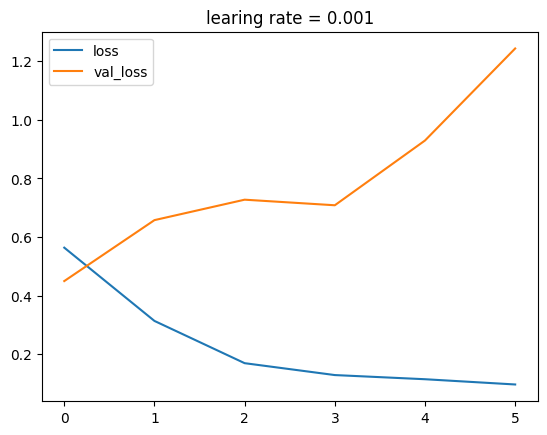

In [20]:
history_df = pd.DataFrame(histories[(0.2, 0.001)].history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = "learing rate = 0.001");

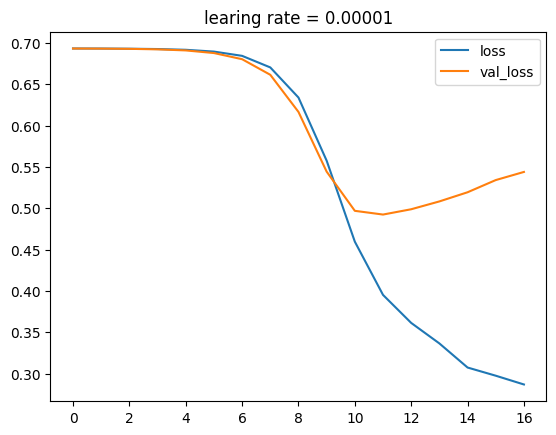

In [21]:
history_df = pd.DataFrame(histories[(0.2, 0.00001)].history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = "learing rate = 0.00001");

For each model with a learning rate of 0.00001 or 0.0001, the training history shows evidence that the model avoids overfitting for at least a few epochs. These are the models most likely to generalize well to new data, at least if we halt training once the signs of eventual overfitting appear. To choose among the models that are somewhat robust against overfitting, we examine F1 scores, the metric on which our models will be assessed using holdout data. F1 scores for all the hyperparameters tested are visualized in the heatmap below.

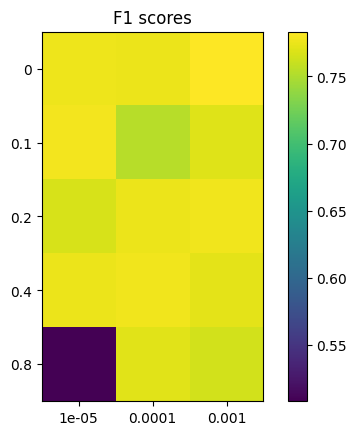

In [22]:
fig, ax = plt.subplots()
im = plt.imshow(f1_scores)
plt.title("F1 scores")
ax.set_xticks(range(3), labels = learning_rates)
ax.set_yticks(range(5), labels = dropout_rates)
plt.colorbar()
plt.show()

Evidently, the hyperparameter settings that lead to the best F1 score are a dropout rate of 0 and a learning rate of 0.0001. In the cell below, we load this model from a dictionary of models we stored during tuning, make predictions, compute an F1 score, and compute a confusion matrix.

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
final model f1 = 0.7746835443037974


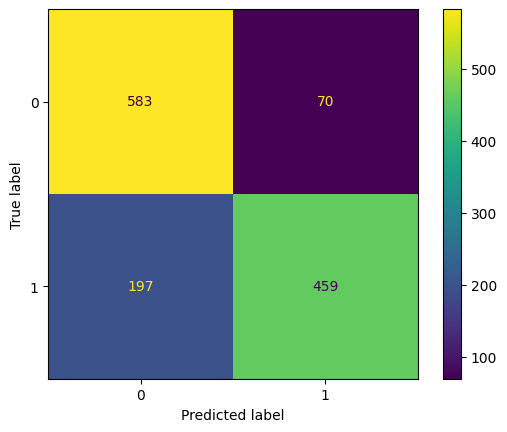

In [23]:
model3 = models[(0,0.0001)]
y_pred = 1*(model3.predict(df_val["text"], verbose = 0) > 0.5)
y_true = np.array(df_val["target"]).reshape(-1,1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(f"final model f1 = {f1(model3)[0]}")

We will validate this model's predictions by submitting its predictions to Kaggle. In the following cells, we import test data with Tweet texts (but no labels), preprocess the data with the same procedure we applied to the rest of our data, and classify the new Tweets using the model with the highest observed F1 score. The result is saved in a file called `submission.csv`.

In [24]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_test["text"] = df_test["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(lemmatize)

In [25]:
y_test = model.predict(df_test["text"])
target = 1*(y_test > 0.5)
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = target
submission.to_csv("submission.csv", index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Kaggle assigns an F1 score of 0.78731 to our submission, which is consistent with the score we computed on our own validation data.

![Leaderboard](https://github.com/mattjanko/disaster_tweets/blob/8f6324094d4b36228139441380406ef01d0dc445/leaderboard.png)

# Conclusion

In this project, we examined three features of the modeling problem presented by the Tweet data:

1. the degree to which the training data is balanced,
2. a dropout rate, and
3. the learning rate.

Though there was only a moderate imbalance in the initial training data (42% positive versus 58% negative), balancing the training data turned out to improve model performance noticeably. However, when trained on both the balanced and imbalanced data, our initial model tended to overfit. We experimented with adding dropout layers to the model as well as employing a lower learning rate to address the overfitting. Based on our tuning procedure, the learning rate appeared to prevent overfitting more effectively than the dropout layers, and in our final model, the dropout rate was set to 0.

Though we achieved a reasonable F1 score using our final model, there is still plenty of room for improvement. One promising way to refine our model further involves the text embedding. We employed a rudimentary method for text embedding in which each unique word was assigned an aribtrary integer. We were careful to lemmatize the words first so that morphologically related words (e.g., "disaster," "Disaster," and "disastrous") were encoded with the same integer. However, words can be related semantically but not mophologically (e.g., "disaster" and "catastrophe"). A potentially more powerful form of preprocessing would involve vectorizing each word in such a way that similar words were represented by nearby vectors or by vectors with a small dot product. A library called GloVe (Global Vectors for Word Representation) provides a set of vectors with this property that can represent two million or more words. Given additional time for development, implementing this kind of word embedding would be our next line of inquiry.

# References

1. [RNN for Text Classifications in NLP](https://www.geeksforgeeks.org/rnn-for-text-classifications-in-nlp/)
2. [Gated Recurrent Unit Networks](https://www.geeksforgeeks.org/gated-recurrent-unit-networks/)
3. [Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)